# LID heuristic vs. reconstruction loss
This notebook mirrors the edge-ratio analysis: we join per-image LID estimates with reconstruction losses for fixed token counts (k), then visualize their relationship with clear, commented code.

In [1]:
"""
Objective: Plot reconstruction loss versus LID (Local Intrinsic Dimensionality) for fixed k values.
This mirrors the edge-ratio analysis and assumes:
- Reconstruction metrics are stored in ../data/datasets/reconstruction_loss_imgnet_train/reconstruction_errors_all.json
- LID values are stored as an ordered list aligned with dataset indices, e.g.:
  ../data/datasets/imageNet_LID_values/train_imageNet_lid_values.json
If your LID path differs, update LID_JSON below.
"""
import json
import numpy as np
import matplotlib.pyplot as plt
import os, sys
import math
sys.path.append(os.path.abspath(".."))  # allow relative imports if needed
print(os.path.abspath(".."))

/BS/data_mani_compress/work/thesis/thesis


In [2]:
# Paths (adjust if your files differ)
RECON_JSON = "/BS/data_mani_compress/work/thesis/thesis/data/datasets/imagenet_reconstruction_losses/val_categorized/all_APG_on.json"

# Load reconstruction dataset (list of dicts with fields: image_id, k_value, vgg_error, mse_error, ...)
with open(RECON_JSON, 'r') as f:
    reconstruction_dataset = json.load(f)

print('Sizes:', len(reconstruction_dataset))

Sizes: 450000


In [6]:
# Paths (adjust if your files differ
LID_JSON   = "/BS/data_mani_compress/work/thesis/thesis/data/datasets/imageNet_LID_values/original_images/val/t_14/lid_0000_3125.json"
print('Using:', LID_JSON)

# Load LID values; we assume it's ordered so that index i corresponds to image i
with open(LID_JSON, 'r') as f:
    lid_values = json.load(f)

print('Sizes:', len(lid_values))

Using: /BS/data_mani_compress/work/thesis/thesis/data/datasets/imageNet_LID_values/original_images/val/t_14/lid_0000_3125.json
Sizes: 50000


In [7]:
# Build dataset-index -> LID lookup.
# The LID file can be a list of numbers or a list of dicts; we extract a numeric value.
lid_by_id = {}
for idx, item in enumerate(lid_values):
    lid_by_id[idx] = float(item)

len(lid_by_id)

50000

Using loss_key=LPIPS; ks=[1, 2, 4, 8, 16, 32, 64, 128, 256]


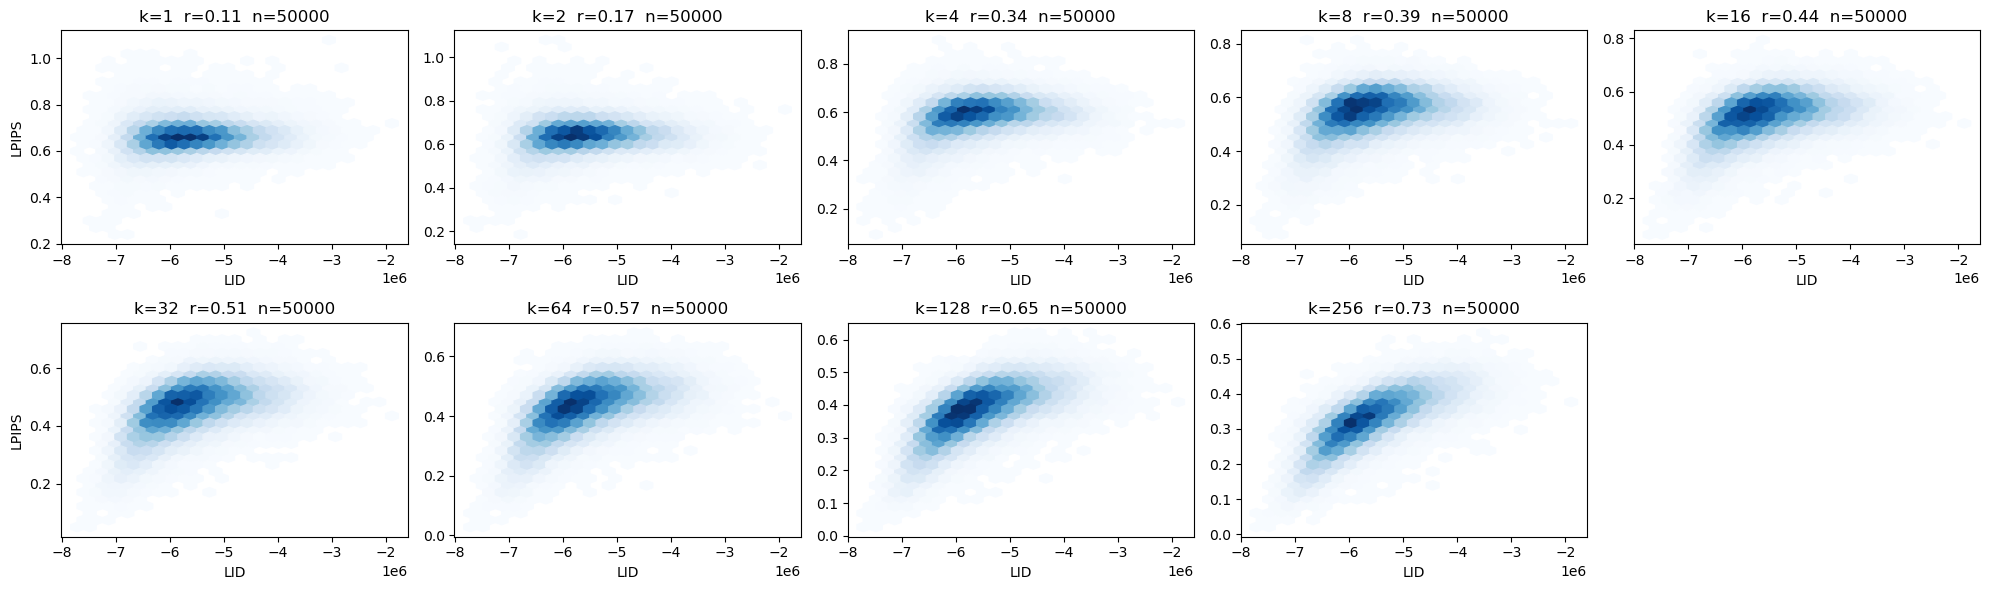

{1: {'n': 50000, 'pearson_r': 0.1055918360378651},
 2: {'n': 50000, 'pearson_r': 0.16548029641451453},
 4: {'n': 50000, 'pearson_r': 0.33582747195110396},
 8: {'n': 50000, 'pearson_r': 0.38736357708942354},
 16: {'n': 50000, 'pearson_r': 0.44363265681835296},
 32: {'n': 50000, 'pearson_r': 0.5070629061293522},
 64: {'n': 50000, 'pearson_r': 0.568747279243295},
 128: {'n': 50000, 'pearson_r': 0.6494669682768126},
 256: {'n': 50000, 'pearson_r': 0.727042019902038}}

In [8]:
# Plot: for each k, scatter LID (x) vs reconstruction loss (y) with a binned trend and correlation.
# This mirrors the edge-ratio grid, with thorough comments for clarity.
# Parameters: choose which reconstruction loss to plot and which k values to include
loss_key = 'LPIPS'                 # or 'L1Loss' DINOv2FeatureLoss LPIPS
ks = [1, 2, 4, 8, 16, 32, 64, 128, 256]  # token counts to visualize
print(f"Using loss_key={loss_key}; ks={ks}")
corr_list = []

ncols = 5
nrows = int(math.ceil(len(ks) / ncols))
fig, axes = plt.subplots(nrows, ncols, figsize=(ncols * 4, nrows * 3), squeeze=False)
axes_f = axes.flatten()

per_k_stats = {}  # {k: {'n': count, 'pearson_r': r}}
for i, k in enumerate(ks):
    ax = axes_f[i]

    # Gather pairs (x=LID, y=loss) for images that match this k and have a LID value
    xs_list, ys_list = [], []
    for rec in reconstruction_dataset:
        if int(rec['k_value']) != int(k):
            continue
        img_id = int(rec['image_id'])
        if img_id not in lid_by_id:
            continue
        xs_list.append(lid_by_id[img_id])       # x-axis: LID
        ys_list.append(float(rec[loss_key]))    # y-axis: reconstruction loss

    xs = np.array(xs_list, dtype=float)
    ys = np.array(ys_list, dtype=float)

    if xs.size > 0:
        # Scatter: small markers + transparency to handle dense plots
        ax.hexbin(xs, ys, gridsize=25, cmap='Blues', mincnt=1)

        # Pearson correlation (linear association); guard against zero variance
        corr = float('nan')
        if xs.size > 1 and np.std(xs) > 0 and np.std(ys) > 0:
            corr = np.corrcoef(xs, ys)[0, 1]
        per_k_stats[int(k)] = {'n': int(xs.size), 'pearson_r': corr}
        ax.set_title(f"k={k}  r={corr:.2f}  n={xs.size}")
    else:
        per_k_stats[int(k)] = {'n': 0, 'pearson_r': float('nan')}
        ax.set_title(f"k={k} (no data)")

    corr_list.append(corr)

    # Label axes (reduce clutter: y-label only on first column)
    if i % ncols == 0:
        ax.set_ylabel(loss_key.replace('_', ' '))  # e.g., 'vgg error' or 'mse error'
    ax.set_xlabel('LID')

# Hide any leftover axes in the grid (when ks doesn't fill all slots)
for j in range(len(ks), len(axes_f)):
    axes_f[j].axis('off')

plt.tight_layout()
plt.show()

per_k_stats

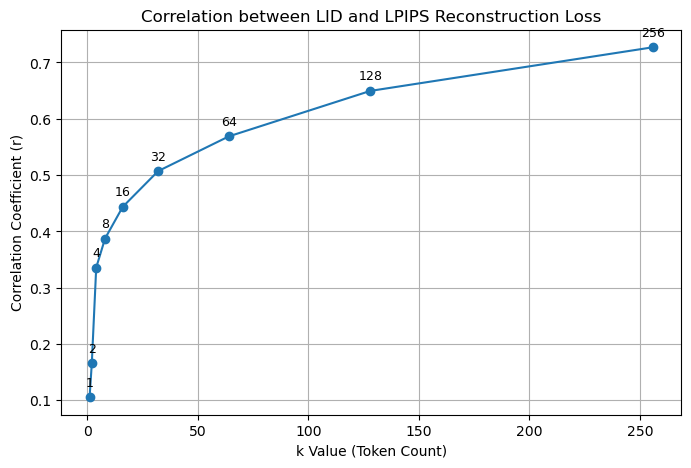

In [9]:
# plot correlation vs k_values
plt.figure(figsize=(8, 5))
plt.plot(ks, corr_list, marker='o')
#plt.xscale('log', base=2)

for x, y in zip(ks, corr_list):
    plt.annotate(
        f"{x}",          # text (x value)
        (x, y),          # point to annotate
        textcoords="offset points",
        xytext=(0, 8),   # offset above the point
        ha='center',
        fontsize=9
    )

plt.xlabel('k Value (Token Count)')
plt.ylabel('Correlation Coefficient (r)')
plt.title('Correlation between LID and LPIPS Reconstruction Loss')
plt.grid(True)
plt.show()

In [10]:
# Paths (adjust if your files differ
LID_JSON_12   = "/BS/data_mani_compress/work/thesis/thesis/data/datasets/imageNet_LID_values/val/t_12/lid_0000_3125.json"
LID_JSON_13   = "/BS/data_mani_compress/work/thesis/thesis/data/datasets/imageNet_LID_values/val/t_13/lid_0000_3125.json"
LID_JSON_14   = "/BS/data_mani_compress/work/thesis/thesis/data/datasets/imageNet_LID_values/val/t_14/lid_0000_3125.json"
LID_JSON_15   = "/BS/data_mani_compress/work/thesis/thesis/data/datasets/imageNet_LID_values/val/t_15/lid_0000_3125.json"
LID_JSON_16   = "/BS/data_mani_compress/work/thesis/thesis/data/datasets/imageNet_LID_values/val/t_16/lid_0000_3125.json"
LID_JSON_17   = "/BS/data_mani_compress/work/thesis/thesis/data/datasets/imageNet_LID_values/val/t_17/lid_0000_3125.json"
LID_JSON_18   = "/BS/data_mani_compress/work/thesis/thesis/data/datasets/imageNet_LID_values/val/t_18/lid_0000_3125.json"
LID_JSON_19   = "/BS/data_mani_compress/work/thesis/thesis/data/datasets/imageNet_LID_values/val/t_19/lid_0000_3125.json"
LID_JSON_20   = "/BS/data_mani_compress/work/thesis/thesis/data/datasets/imageNet_LID_values/val/t_20/lid_0000_3125.json"
LID_JSON_21   = "/BS/data_mani_compress/work/thesis/thesis/data/datasets/imageNet_LID_values/val/t_21/lid_0000_3125.json"
LID_JSON_22   = "/BS/data_mani_compress/work/thesis/thesis/data/datasets/imageNet_LID_values/val/t_22/lid_0000_3125.json"
LID_JSON_23   = "/BS/data_mani_compress/work/thesis/thesis/data/datasets/imageNet_LID_values/val/t_23/lid_0000_3125.json"
LID_JSON_24   = "/BS/data_mani_compress/work/thesis/thesis/data/datasets/imageNet_LID_values/val/t_24/lid_0000_3125.json"
LID_JSON_25   = "/BS/data_mani_compress/work/thesis/thesis/data/datasets/imageNet_LID_values/val/t_25/lid_0000_3125.json"
LID_JSON_26   = "/BS/data_mani_compress/work/thesis/thesis/data/datasets/imageNet_LID_values/val/t_26/lid_0000_3125.json"
LID_JSON_27   = "/BS/data_mani_compress/work/thesis/thesis/data/datasets/imageNet_LID_values/val/t_27/lid_0000_3125.json"
LID_JSON_28   = "/BS/data_mani_compress/work/thesis/thesis/data/datasets/imageNet_LID_values/val/t_28/lid_0000_3125.json"

# load all the json files
lid_values_all = {}
for idx, lid_json in enumerate([LID_JSON_12, LID_JSON_13, LID_JSON_14, LID_JSON_15, LID_JSON_16,
                 LID_JSON_17, LID_JSON_18, LID_JSON_19, LID_JSON_20,
                 LID_JSON_21, LID_JSON_22, LID_JSON_23, LID_JSON_24,
                 LID_JSON_25, LID_JSON_26, LID_JSON_27, LID_JSON_28]):
    with open(lid_json, 'r') as f:
        lid_values = json.load(f)
    lid_values_all[idx] = lid_values
print('Sizes:', len(lid_values_all))

FileNotFoundError: [Errno 2] No such file or directory: '/BS/data_mani_compress/work/thesis/thesis/data/datasets/imageNet_LID_values/val/t_12/lid_0000_3125.json'

In [ ]:
print('Sizes:', len(lid_values_all))

Sizes: 17


Best noise timestep per k (by |Pearson r|): for LPIPS
k=  1 best_t=26 r=0.167 pairs=50000
k=  2 best_t=26 r=0.235 pairs=50000
k=  4 best_t=25 r=0.391 pairs=50000
k=  8 best_t=25 r=0.453 pairs=50000
k= 16 best_t=24 r=0.499 pairs=50000
k= 32 best_t=24 r=0.544 pairs=50000
k= 64 best_t=23 r=0.577 pairs=50000
k=128 best_t=14 r=0.649 pairs=50000
k=256 best_t=14 r=0.727 pairs=50000


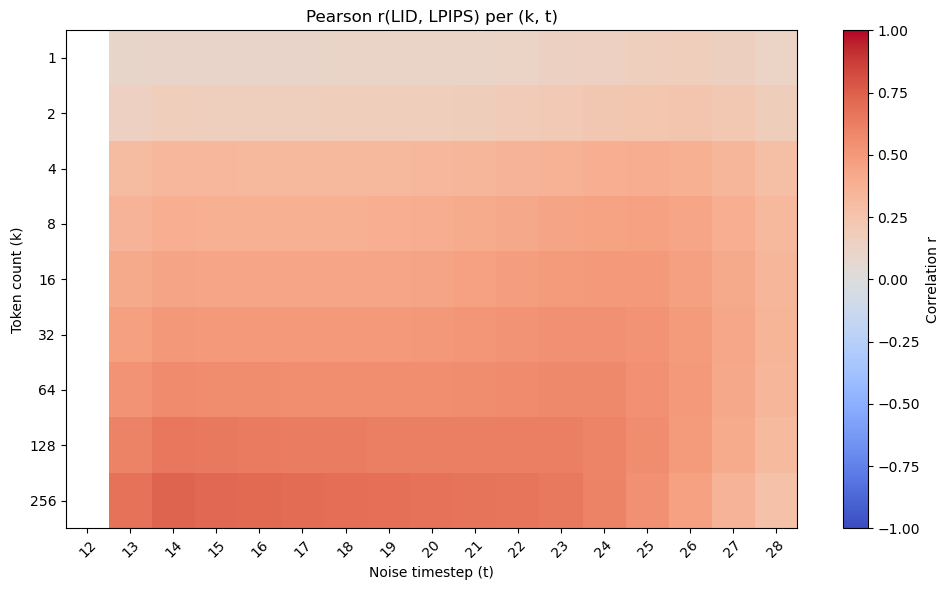

{1: {'best_timestep': 26,
  'best_corr': 0.16703839019728622,
  'all_corrs': {12: nan,
   13: 0.09670263871734971,
   14: 0.1055918360378651,
   15: 0.10553247973111933,
   16: 0.10675463857220006,
   17: 0.10836938146700857,
   18: 0.10977870980207895,
   19: 0.11071663839134818,
   20: 0.11173821470016881,
   21: 0.11451748938468653,
   22: 0.12202575422932156,
   23: 0.13372259905574843,
   24: 0.14815933178815371,
   25: 0.16096616367105884,
   26: 0.16703839019728622,
   27: 0.15346126195301965,
   28: 0.11764149578944555},
  'n_pairs_at_best': 50000},
 2: {'best_timestep': 26,
  'best_corr': 0.23463323776429593,
  'all_corrs': {12: nan,
   13: 0.1426797112004366,
   14: 0.16548029641451453,
   15: 0.1620124717908474,
   16: 0.16149616248274054,
   17: 0.16254195340618413,
   18: 0.16419061225238393,
   19: 0.16626733033292407,
   20: 0.16974377451748915,
   21: 0.17605563803719948,
   22: 0.18773278136863236,
   23: 0.20429194536188705,
   24: 0.22214270544177558,
   25: 0.234131

In [ ]:

# for each token count find the best noise level (highest correlation)
# first find the correlation between reconstruction loss at different token counts and LID for each noise level
# for each token count k, for each noise level t, compute correlation between reconstruction loss and LID

# For each token count k, find the noise level (t) with highest |correlation| between LID and reconstruction loss.
# Uses lid_values_all (dict index -> list of LID values) and reconstruction_dataset.
# Assumes lid_values_all indices map to actual noise timesteps defined below
ks = [1, 2, 4, 8, 16, 32, 64, 128, 256]
loss_key = 'LPIPS'  # or 'L1Loss' 'LPIPS' or 'DINOv2FeatureLoss'

# Map lid_values_all dict indices to their actual timestep labels (t_12 .. t_28)
noise_timesteps = list(range(12, 29))  # 12..28 inclusive
if len(noise_timesteps) != len(lid_values_all):
    print(f"[Warning] len(noise_timesteps)={len(noise_timesteps)} != len(lid_values_all)={len(lid_values_all)}; adjusting to dict length.")
    noise_timesteps = noise_timesteps[:len(lid_values_all)]

# Build reconstruction losses per k keyed by image_id for fast lookup
# {k: {image_id: loss_value}}
loss_by_k = {int(k): {} for k in ks}
for rec in reconstruction_dataset:
    k_val = int(rec.get('k_value', -1))
    if k_val in loss_by_k and loss_key in rec:
        loss_by_k[k_val][int(rec['image_id'])] = float(rec[loss_key])

# Function to compute Pearson correlation robustly
import numpy as _np

def _pearson(x, y):
    x = _np.asarray(x, dtype=float)
    y = _np.asarray(y, dtype=float)
    if x.size < 2 or y.size < 2:
        return _np.nan
    if _np.std(x) == 0 or _np.std(y) == 0:
        return _np.nan
    return float(_np.corrcoef(x, y)[0, 1])

best_noise_per_k = {}
correlation_matrix = []  # rows: k, cols: noise timesteps

for k in ks:
    k = int(k)
    k_losses = loss_by_k[k]
    per_t_corrs = {}
    for idx, t in enumerate(noise_timesteps):
        lid_list = lid_values_all.get(idx, [])
        # Pair up image_id present in both k_losses and lid_list range
        xs, ys = [], []
        for img_id, loss_val in k_losses.items():
            if img_id < len(lid_list):  # ensure lid exists
                xs.append(float(lid_list[img_id]))
                ys.append(loss_val)
        r = _pearson(xs, ys)
        per_t_corrs[t] = r
    # Determine best timestep (highest absolute correlation)
    # Could choose signed; here we choose magnitude to reflect strongest relationship
    best_t, best_r = max(per_t_corrs.items(), key=lambda kv: abs(kv[1]) if not _np.isnan(kv[1]) else -1)
    best_noise_per_k[k] = {
        'best_timestep': best_t,
        'best_corr': best_r,
        'all_corrs': per_t_corrs,
        'n_pairs_at_best': sum(
            1 for img_id in loss_by_k[k]
            if img_id < len(lid_values_all[noise_timesteps.index(best_t)])
        ),
    }
    # Store ordered correlations for matrix (align to noise_timesteps order)
    correlation_matrix.append([per_t_corrs[t] for t in noise_timesteps])

print(f"Best noise timestep per k (by |Pearson r|): for {loss_key}" )
for k in ks:
    info = best_noise_per_k[int(k)]
    print(f"k={k:>3} best_t={info['best_timestep']:>2} r={info['best_corr']:.3f} pairs={info['n_pairs_at_best']}")

# Optional: visualize correlation heatmap (k vs noise timestep)
try:
    import matplotlib.pyplot as plt
    import numpy as np
    corr_arr = np.array(correlation_matrix)
    fig, ax = plt.subplots(figsize=(10, 6))
    im = ax.imshow(corr_arr, aspect='auto', cmap='coolwarm', vmin=-1, vmax=1)
    ax.set_xticks(range(len(noise_timesteps)))
    ax.set_xticklabels(noise_timesteps, rotation=45)
    ax.set_yticks(range(len(ks)))
    ax.set_yticklabels(ks)
    ax.set_xlabel('Noise timestep (t)')
    ax.set_ylabel('Token count (k)')
    ax.set_title(f'Pearson r(LID, {loss_key}) per (k, t)')
    fig.colorbar(im, ax=ax, label='Correlation r')
    plt.tight_layout()
    plt.show()
except Exception as e:
    print(f"[Heatmap skipped] {e}")

best_noise_per_k

